In [47]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.io import ascii
from astropy.table import Table
#from merger_analysis import athena_read as ar
#from glob import glob
#from matplotlib.colors import LinearSegmentedColormap
from merger_analysis import OrbitAnalysisUtils as ou
from Constants import Constants
import seaborn as sns

from mpl_toolkits.axes_grid1 import ImageGrid


#reload(ou)
#reload(ar)

c=Constants()

%matplotlib inline

# set some global options
plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.2
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 16


root_dir_morgan = "/Volumes/DATAVolume2/athenaruns/pm_envelope/pole/param_survey/"

# Fig1: Donor Mass-Radius

In [6]:
# COmputed in Polytropic_Envelope.ipynb
mr43_43 = ascii.read('../data/mass_radius/mass_radius_43_43.dat')
mr43_15 = ascii.read('../data/mass_radius/mass_radius_43_15.dat')
mr43_53 = ascii.read('../data/mass_radius/mass_radius_43_53.dat')
mr53_53 = ascii.read('../data/mass_radius/mass_radius_53_53.dat')

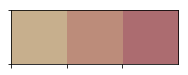

In [7]:
pal=sns.cubehelix_palette(3,start=0., rot=0.6,light=0.7,dark=.5)
sns.palplot(pal)

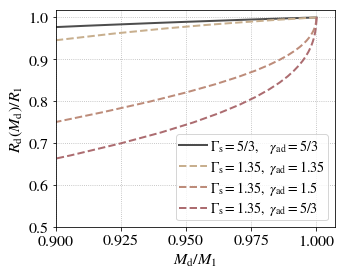

In [9]:
plt.figure(figsize=(5,4.))
plt.plot(mr53_53['m'],mr53_53['r']/mr53_53['r'][0],lw=2,color='0.3',label=r'$\Gamma_{\rm s}=5/3, \ \ \ \gamma_{\rm ad}=5/3$')
plt.plot(mr43_43['m'],mr43_43['r']/mr43_43['r'][0],lw=2,ls='--',color=pal[0],label=r'$\Gamma_{\rm s}=1.35, \ \gamma_{\rm ad}=1.35$')
plt.plot(mr43_15['m'],mr43_15['r']/mr43_15['r'][0],lw=2,ls='--',color=pal[1],label=r'$\Gamma_{\rm s}=1.35, \ \gamma_{\rm ad}=1.5$')
plt.plot(mr43_53['m'],mr43_53['r']/mr43_53['r'][0],lw=2,ls='--',color=pal[2],label=r'$\Gamma_{\rm s}=1.35, \ \gamma_{\rm ad}=5/3$')

plt.ylabel(r'$R_{\rm d}(M_{\rm d})/R_1$')
plt.xlabel(r'$M_{\rm d}/M_1$')

plt.xlim(0.9,)
plt.ylim(0.5,)
plt.grid(ls=':')
plt.legend(loc=0,frameon=True)

plt.savefig("../figures/donor_MR.pdf",bbox_inches='tight')


# Fig 2: Mdot vs time, sep

In [23]:
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
from scipy.optimize import minimize_scalar
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

st = ascii.read("../data/summary_table/sim_table_bu.dat")


mr43_43 = ascii.read('../data/mass_radius/mass_radius_43_43.dat')
mr43_15 = ascii.read('../data/mass_radius/mass_radius_43_15.dat')
mr43_53 = ascii.read('../data/mass_radius/mass_radius_43_53.dat')
mr53_53 = ascii.read('../data/mass_radius/mass_radius_53_53.dat')

# Interpolating functions
R53_53 = interp1d(mr53_53['m'],mr53_53['r'])
R43_53 = interp1d(mr43_53['m'],mr43_53['r'])
R43_15 = interp1d(mr43_15['m'],mr43_15['r'])
R43_43 = interp1d(mr43_43['m'],mr43_43['r'])



def read_hst(fn,orb):
    hst = ascii.read(fn,
                 names=['time','dt','mass','1-mom','2-mom','3-mom','1-KE','2-KE','3-KE','tot-E','mxOmegaEnv','mEnv','mr1','mr12'])
    hst['sep'] = np.interp(hst['time'],orb['time'],orb['sep'])
    hst['mdot'] = np.gradient(hst['mr1'])/np.gradient(hst['time'])
    mdsmooth = convolve(hst['mdot'],Box1DKernel(10),boundary='extend')  # 1 tdyn
    select = hst['sep']>0.75*a_RL(orb['m2'][0])
    mdsmooth[select] = convolve(mdsmooth[select],Box1DKernel(30),boundary='extend') # 3 tdyn
    select = hst['sep']>0.9*a_RL(orb['m2'][0])
    mdsmooth[select] = convolve(mdsmooth[select],Box1DKernel(100),boundary='extend') # 10 tdyn
    hst['mdotsmooth'] = mdsmooth
    
    hst['M2'] = np.interp(hst['time'],orb['time'],orb['m2'])
    hst['M1'] = orb['m1'][0]+hst['mr1']
    return hst


def a_RL(q):
    """Eggelton formula, q=M2/M1 (opposite of eggelton deff) 
    this is: a/rL where a is separation and rL is the Roche Lobe radius"""
    return (0.6*q**(-2./3.) + np.log(1+q**(-1./3.)))/(0.49*q**(-2./3.))

def p_orb(Mtot,a,G):
    """Orbital period"""
    return 2*np.pi*np.sqrt(a**3/(G*Mtot))

def mdot_donor(a,m1,m2,r1,n1,G):
    """Pols eqn 7.5"""
    rL = a_RL(m2/m1)**-1 * a
    A = 1.0
    mdot = -A*m1/p_orb(m1+m2,a,G)*((r1-rL)/r1)**(n1+1.5)
    return np.select([mdot<0,mdot>=0],[mdot,0])


def get_alpha_mdot(base_dir,radius_function,n_poly):
    orb = ou.read_trackfile(base_dir+'pm_trackfile.dat')
    hst = read_hst(base_dir+"HSE.hst",orb)
    t1 = ou.get_t1(orb)
    
    rot_radius_factor = st[st['dir']==root_dir_morgan+base_dir[8:]]['Rd_rot'][0]/radius_function(1)
    #print "rot_radius_factor = ",rot_radius_factor
    
    # Get the best-fit alpha
    xp = np.linspace(1,hst['sep'][0]-0.02,100)
    yp = np.log10(np.interp(xp,np.flipud(hst['sep']),np.flipud(-hst['mdotsmooth']) ))
    m1p = np.interp(xp,np.flipud(hst['sep']),np.flipud(hst['M1']) )
    m2p = np.interp(xp,np.flipud(hst['sep']),np.flipud(hst['M2']) )

    def sum_sq(alpha):
        yp_model = np.log10(- alpha * mdot_donor(a=xp,
                                      m1=m1p,
                                      m2=m2p,
                                      r1=rot_radius_factor*radius_function(m1p),
                                      n1=n_poly,G=1.))

        return np.sum((yp-yp_model)**2)


    alpha = minimize_scalar(sum_sq).x
    return alpha


def make_mdot_plot(base_dir,radius_function,n_poly):
    orb = ou.read_trackfile(base_dir+'pm_trackfile.dat')
    hst = read_hst(base_dir+"HSE.hst",orb)
    t1 = ou.get_t1(orb)
    
    rot_radius_factor = st[st['dir']==root_dir_morgan+base_dir[8:]]['Rd_rot'][0]/radius_function(1)
    print "rot_radius_factor = ",rot_radius_factor
    alpha = get_alpha_mdot(base_dir,radius_function,n_poly)
    print "alpha =",alpha
    
    sel = hst['time']>30.
    

    #plt.figure(figsize=(8,3.5))
    plt.subplot(121)
    #plt.plot(hst[sel]['time']-t1,-hst[sel]['mdot'],color='0.9',label='simulation (instantaneous)')
    plt.plot(hst[sel]['time']-t1,-hst[sel]['mdotsmooth'],label='simulation (smoothed)')
    plt.plot(hst[sel]['time']-t1,-alpha * mdot_donor(a=hst[sel]['sep'],
                                            m1=hst[sel]['M1'],
                                            m2=hst[sel]['M2'],
                                            r1=rot_radius_factor*radius_function(hst[sel]['M1']),
                                            n1=n_poly,G=1.),
             '--',label=r'analytic, $\alpha=$'+str(np.round(alpha,decimals=2)) )
    plt.yscale('log')
    plt.grid(ls=':')
    plt.ylabel(r"$|\dot M_{\rm d}| \ \ [M_1/t_{\rm dyn,1}]$")
    plt.xlabel(r"time, $t-t_1 \ \ [t_{\rm dyn,1}]$")
    #plt.legend(frameon=True,loc='upper left')
    plt.ylim(3.e-8,0.1)
    
    plt.subplot(122)
    #plt.plot(hst[sel]['sep'],-hst[sel]['mdot'],color='0.9')
    plt.plot(hst[sel]['sep'],-hst[sel]['mdotsmooth'])
    plt.plot(hst[sel]['sep'],-alpha * mdot_donor(a=hst[sel]['sep'],
                                            m1=hst[sel]['M1'],
                                            m2=hst[sel]['M2'],
                                            r1=rot_radius_factor*radius_function(hst[sel]['M1']),
                                            n1=n_poly,G=1.),
             '--',label=r'analytic, $\alpha=$'+str(np.round(alpha,decimals=2)) )
    
    plt.yscale('log')
    plt.grid(ls=':')
    plt.yticks(visible=False)
    plt.xlabel('separation $[R_1]$')
    plt.xticks([1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.,2.1])
    plt.xlim(1,hst['sep'][0])
    plt.ylim(3.e-8,0.1)
    
    plt.subplots_adjust(wspace=0)
    
    return alpha

def make_mdot_plot_twopanel(base_dir,radius_function,n_poly):
    orb = ou.read_trackfile(base_dir+'pm_trackfile.dat')
    hst = read_hst(base_dir+"HSE.hst",orb)
    t1 = ou.get_t1(orb)
    
    rot_radius_factor = st[st['dir']==root_dir_morgan+base_dir[8:]]['Rd_rot'][0]/radius_function(1)
    print "rot_radius_factor = ",rot_radius_factor
    alpha = get_alpha_mdot(base_dir,radius_function,n_poly)
    print "alpha =",alpha
    
    sel = hst['time']>30.
    

    #plt.figure(figsize=(8,3.5))
    plt.subplot(121)
    #plt.plot(hst[sel]['time']-t1,-hst[sel]['mdot'],color='0.9',label='simulation (instantaneous)')
    plt.plot(hst[sel]['time']-t1,-hst[sel]['mdotsmooth'],'k-',label='simulation')
    plt.plot(hst[sel]['time']-t1,-alpha * mdot_donor(a=hst[sel]['sep'],
                                            m1=hst[sel]['M1'],
                                            m2=hst[sel]['M2'],
                                            r1=rot_radius_factor*radius_function(hst[sel]['M1']),
                                            n1=n_poly,G=1.),
             '--',color='C1',label=r'analytic, $\alpha=$'+str(np.round(alpha,decimals=2)) )
    plt.yscale('log')
    plt.grid(ls=':')
    plt.ylabel(r"$|\dot M_{\rm d}| \ \ [M_1/t_{\rm dyn,1}]$")
    plt.xlabel(r"time, $t-t_1 \ \ [t_{\rm dyn,1}]$")
    plt.legend(frameon=True,loc='upper left')
    plt.ylim(3.e-6,0.1)
    
    plt.subplot(122)
    #plt.plot(hst[sel]['sep'],-hst[sel]['mdot'],color='0.9')
    plt.plot(hst[sel]['sep'],-hst[sel]['mdotsmooth'],'k')
    plt.plot(hst[sel]['sep'],-alpha * mdot_donor(a=hst[sel]['sep'],
                                            m1=hst[sel]['M1'],
                                            m2=hst[sel]['M2'],
                                            r1=rot_radius_factor*radius_function(hst[sel]['M1']),
                                            n1=n_poly,G=1.),
             '--',color='C1',label=r'analytic, $\alpha=$'+str(np.round(alpha,decimals=2)) )
    
    plt.yscale('log')
    plt.grid(ls=':')
    plt.yticks(visible=False)
    plt.xlabel('separation $[R_1]$')
    plt.xticks([1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.,2.1])
    plt.xlim(1,hst['sep'][0])
    plt.ylim(3.e-6,0.1)
    
    plt.subplots_adjust(wspace=0)
    
    return

reading orbit file for binary simulation...
rot_radius_factor =  1.049608703658635
reading orbit file for binary simulation...


/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


alpha = 0.7136899007866753


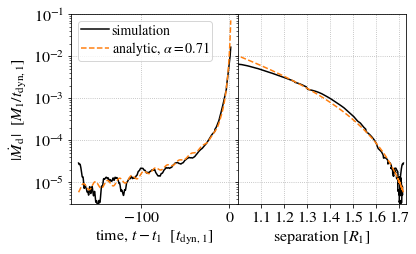

In [24]:
plt.figure(figsize=(6,3.5))
make_mdot_plot_twopanel("../data/synchronization/q01/fc10/",R53_53,1.5)
plt.savefig("../figures/mdot_time_sep.pdf",bbox_inches='tight')

# Fig 3: Mdot Sep Variations

In [25]:
from scipy.optimize import minimize_scalar

def make_mdot_plot_onepanel(base_dir,radius_function,n_poly,color='red',label=""):
    orb = ou.read_trackfile(base_dir+'pm_trackfile.dat')
    hst = read_hst(base_dir+"HSE.hst",orb)
    t1 = ou.get_t1(orb)
    
    rot_radius_factor = st[st['dir']==root_dir_morgan+base_dir[8:]]['Rd_rot'][0]/radius_function(1)
    print "rot_radius_factor = ",rot_radius_factor
    alpha = get_alpha_mdot(base_dir,radius_function,n_poly)
    print "alpha =",alpha
    
    sel = hst['time']>30.
    
    #plt.plot(hst[sel]['sep'],-hst[sel]['mdot'],color='0.9')
    plt.plot(hst[sel]['sep'],-hst[sel]['mdotsmooth'],color=color ,label=label,lw=2)
    plt.plot(hst[sel]['sep'],-alpha * mdot_donor(a=hst[sel]['sep'],
                                            m1=hst[sel]['M1'],
                                            m2=hst[sel]['M2'],
                                            r1=rot_radius_factor*radius_function(hst[sel]['M1']),
                                            n1=n_poly,G=1.),
             '--',label='',#label=r'analytic, $\alpha=$'+str(np.round(alpha,decimals=2)),
             color=color,zorder=0 )
    
    plt.yscale('log')
    plt.grid(ls=':')
    plt.yticks(visible=False)
    plt.xlabel('separation $[R_1]$')
    plt.xticks([1.2,1.4,1.6,1.8,2.,2.2])
    plt.xlim(1,hst['sep'][0])
    plt.ylim(3.e-6,0.2)
    
    plt.subplots_adjust(wspace=0)
    
    return


reading orbit file for binary simulation...
rot_radius_factor =  1.0696866689130626
reading orbit file for binary simulation...
alpha = 0.254745300746007


/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


reading orbit file for binary simulation...
rot_radius_factor =  1.049608703658635
reading orbit file for binary simulation...
alpha = 0.7136899007866753
reading orbit file for binary simulation...
rot_radius_factor =  1.037914277212505
reading orbit file for binary simulation...
alpha = 1.2106452296029218
reading orbit file for binary simulation...
rot_radius_factor =  1.0119642521243402
reading orbit file for binary simulation...
alpha = 1.1635320768139743
reading orbit file for binary simulation...
rot_radius_factor =  1.0134491818686497
reading orbit file for binary simulation...
alpha = 0.9711639537614913
reading orbit file for binary simulation...
rot_radius_factor =  1.026525334824165
reading orbit file for binary simulation...
alpha = 0.8176712736545187
reading orbit file for binary simulation...
rot_radius_factor =  1.049608703658635
reading orbit file for binary simulation...
alpha = 0.7136899007866753
reading orbit file for binary simulation...
rot_radius_factor =  1.0490342

/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:2315: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


alpha = 2.640141574705093
reading orbit file for binary simulation...
rot_radius_factor =  1.032293056206359
reading orbit file for binary simulation...
alpha = 1.0807791505598392
reading orbit file for binary simulation...
rot_radius_factor =  1.051156621865787
reading orbit file for binary simulation...
alpha = 0.7151727153035888


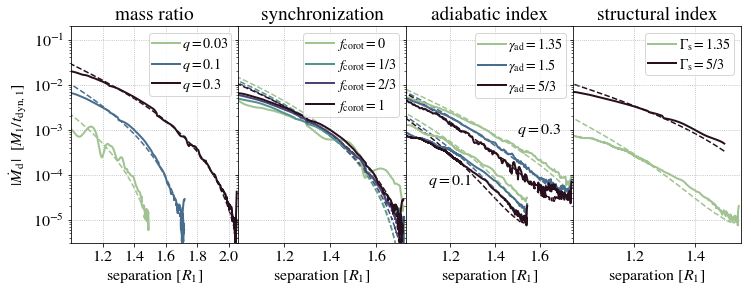

In [26]:
plt.figure(figsize=(12,4))

# Mass Ratio
plt.subplot(141)
plt.title('mass ratio')
pal=sns.cubehelix_palette(3,start=0.9, rot=-1,light=0.7,dark=.1)
make_mdot_plot_onepanel("../data/mass_ratio/fc10/q003/",R53_53,1.5,
                        label=r'$q=0.03$',color=pal[0])
make_mdot_plot_onepanel("../data/synchronization/q01/fc10/",R53_53,1.5,
                        label=r'$q=0.1$',color=pal[1])
make_mdot_plot_onepanel("../data/mass_ratio/fc10/q03/",R53_53,1.5,
                        label=r'$q=0.3$',color=pal[2])
plt.legend(loc='upper right',frameon=True)
plt.yticks(visible=True)
plt.ylabel(r"$|\dot M_{\rm d}| \ \ [M_1/t_{\rm dyn,1}]$")

# Synchronization
plt.subplot(142)
plt.title('synchronization')
pal=sns.cubehelix_palette(4,start=0.9, rot=-1,light=0.7,dark=.1)
make_mdot_plot_onepanel("../data/synchronization/q01/fc0/",R53_53,1.5,
              label=r'$f_{\rm corot}=0$',color=pal[0])
make_mdot_plot_onepanel("../data/synchronization/q01/fc033/",R53_53,1.5,
               label=r'$f_{\rm corot}=1/3$',color=pal[1])
make_mdot_plot_onepanel("../data/synchronization/q01/fc066/",R53_53,1.5,
               label=r'$f_{\rm corot}=2/3$',color=pal[2])
make_mdot_plot_onepanel("../data/synchronization/q01/fc10/",R53_53,1.5,
               label=r'$f_{\rm corot}=1$',color=pal[3])
plt.legend(loc='upper right',frameon=True)


# Adiabatic Index
plt.subplot(143)
plt.title('adiabatic index')
pal=sns.cubehelix_palette(3,start=0.9, rot=-1,light=0.7,dark=.1)
make_mdot_plot_onepanel("../data/structure_43/q01/a15/gs43_ga43/",R43_43,1/0.35,
                        label=r'$\gamma_{\rm ad}=1.35$',color=pal[0])
make_mdot_plot_onepanel("../data/structure_43/q01/a15/gs43_ga15/",R43_15,1/0.35,
                        label=r'$\gamma_{\rm ad}=1.5$',color=pal[1])
make_mdot_plot_onepanel("../data/structure_43/q01/a15/gs43_ga53/",R43_53,1/0.35,
                        label=r'$\gamma_{\rm ad}=5/3$',color=pal[2])
plt.legend(loc='upper right',frameon=True)

make_mdot_plot_onepanel("../data/structure_43/q03/gs43_ga43/",R43_43,1/0.35,
                        label=r'$\gamma_{\rm ad}=1.35$',color=pal[0])
make_mdot_plot_onepanel("../data/structure_43/q03/gs43_ga15/",R43_15,1/0.35,
                        label=r'$\gamma_{\rm ad}=1.5$',color=pal[1])
make_mdot_plot_onepanel("../data/structure_43/q03/gs43_ga53/",R43_53,1/0.35,
                        label=r'$\gamma_{\rm ad}=5/3$',color=pal[2])

plt.annotate(r"$q=0.1$",(1.1,6.e-5))
plt.annotate(r"$q=0.3$",(1.5,8.e-4))


# Structural Index
plt.subplot(144)
plt.title('structural index')
pal=sns.cubehelix_palette(2,start=0.9, rot=-1,light=0.7,dark=.1)
make_mdot_plot_onepanel("../data/structure_43/q01/a15/gs43_ga53/",R43_53,1/0.35,
                         label=r'$\Gamma_{\rm s}=1.35$',color=pal[0])
make_mdot_plot_onepanel("../data/separation/q01/a17/",R53_53,1.5,
                         label=r'$\Gamma_{\rm s}=5/3$',color=pal[1])
plt.legend(loc='upper right',frameon=True)

plt.savefig("../figures/mdot_variations.pdf",bbox_inches='tight')

# Fig 4: $\langle \alpha \rangle$

In [27]:
def approx_alpha(q, fcorot, gad, gs, amplitude=1.0, alpha=1.,beta=1,gamma=1,a=1.):
    """approximation of alpha_modt"""
    return amplitude * (q/0.1)**alpha * (gad/(5/3.))**beta * (gs/(5/3.))**gamma  * (1 + a*(fcorot-1.) )

def lsq_alpha(param_array,st=st):
    amplitude,alpha,beta,gamma,a=param_array
    return np.sum( (st['alpha_mdot']-approx_alpha(st['m2'],st['fcorot'],st['gamma_ad'],st['gamma_structure'],
                                 amplitude=amplitude,alpha=alpha,beta=beta,gamma=gamma,a=a))**2 )
    

In [28]:
from scipy.optimize import minimize 

sel = st['m2'] > 0.01
fit = minimize(lsq_alpha,np.array([1,1,1,1,1]),args=(st[sel]))
print fit
amplitude,alpha,beta,gamma,a=np.round(fit.x,2)
st['alpha_mdot_fit'] = approx_alpha(st['m2'],st['fcorot'],st['gamma_ad'],st['gamma_structure'],
                                   amplitude=amplitude,alpha=alpha,beta=beta,gamma=gamma,a=a)

      fun: 0.061919933574727956
 hess_inv: array([[ 1.01341569e-01, -6.98500809e-02,  7.41393426e-03,
         5.19917631e-01,  3.55440888e-01],
       [-6.98500809e-02,  1.52447900e-01, -7.49103833e-03,
         9.50291658e-02, -2.39966386e-01],
       [ 7.41393426e-03, -7.49103833e-03,  8.43785706e+00,
        -1.53733010e+00, -8.13244399e-02],
       [ 5.19917631e-01,  9.50291658e-02, -1.53733010e+00,
         5.93816231e+00,  1.89345739e+00],
       [ 3.55440888e-01, -2.39966386e-01, -8.13244399e-02,
         1.89345739e+00,  2.06141902e+00]])
      jac: array([-2.30781734e-06,  1.30385160e-08,  4.33064997e-07,  4.84287739e-08,
        4.08850610e-07])
  message: 'Optimization terminated successfully.'
     nfev: 182
      nit: 22
     njev: 26
   status: 0
  success: True
        x: array([ 0.61630211,  0.682493  ,  5.38775522, -3.24653   , -0.88759174])


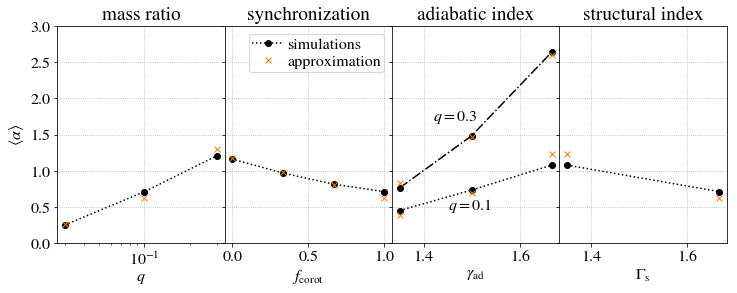

In [29]:

plt.figure(figsize=(12,4))

# Mass Ratio
plt.subplot(141)
plt.title('mass ratio')
sel = (st['fcorot']==1) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
plt.plot(st[sel][[1,0,2]]['m2'],st[sel][[1,0,2]]['alpha_mdot'],'ko:',label='simulations')
plt.ylim(0,3)
#plt.xlim(0.01,1/3.)
plt.grid(ls=":")
plt.xscale('log')
plt.xlabel(r'$q$')
plt.ylabel(r'$\langle\alpha\rangle$')

plt.plot(st[sel]['m2'],st[sel]['alpha_mdot_fit'],'C1x')

# Synchronization
plt.subplot(142)
plt.title('synchronization')
sel = ((st['m2']==0.1) & (st['gamma_structure']==5./3.)  & (st['a0']!=1.55))
plt.plot(st[sel]['fcorot'],st[sel]['alpha_mdot'],'ko:',label='simulations')
plt.ylim(0,3)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r'$f_{\rm corot}$')

plt.plot(st[sel]['fcorot'],st[sel]['alpha_mdot_fit'],'C1x',label=r'approximation')
plt.legend(loc='upper right',frameon=True,fontsize=16)


# Adiabatic Index
plt.subplot(143)
plt.title('adiabatic index')
sel = ( (st['m2']==0.1) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel]['alpha_mdot'],'ko:',label='simulations')
plt.ylim(0,3)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r"$\gamma_{\rm ad}$")

plt.plot(st[sel]['gamma_ad'],st[sel]['alpha_mdot_fit'],'C1x')

sel = ( (st['m2']==0.3) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],st[sel]['alpha_mdot'],'ko-.',label='simulations')
plt.ylim(0,3)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r"$\gamma_{\rm ad}$")

plt.plot(st[sel]['gamma_ad'],st[sel]['alpha_mdot_fit'],'C1x')

plt.annotate(r"$q=0.3$",(1.42,1.7))
plt.annotate(r"$q=0.1$",(1.45,0.47))


# Structural Index
plt.subplot(144)
plt.title('structural index')
sel = ((st['m2']==0.1) & (st['gamma_ad']==5./3.) & (st['fcorot']==1.0) & (st['a0']==1.55))
plt.plot(st[sel]['gamma_structure'],st[sel]['alpha_mdot'],'ko:',label='simulations')
plt.ylim(0,3)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r"$\Gamma_{\rm s}$")

plt.plot(st[sel]['gamma_structure'],st[sel]['alpha_mdot_fit'],'C1x')

plt.subplots_adjust(wspace=0)

plt.savefig("../figures/mdot_alpha_variations.pdf",bbox_inches='tight')


In [30]:
np.round(fit.x,2)

array([ 0.62,  0.68,  5.39, -3.25, -0.89])

# Fig 5: $\langle \gamma_{\rm loss} \rangle$

In [31]:
def approx_gamma(q, fcorot, gad, gs, amplitude=1.0, alpha=1.,beta=1,gamma=1,a=1.):
    """approximation of gamma_loss"""
    return amplitude * (q/0.1)**alpha * (gad/(5/3.))**beta * (gs/(5/3.))**gamma  * (1 + a*(fcorot-1.) )

def lsq_gamma(param_array,st=st):
    amplitude,alpha,beta,gamma,a=param_array
    return np.sum( ((st['gl1']-st['gamma_d'])/(st['gamma_l2']-st['gamma_d'])-approx_gamma(st['m2'],st['fcorot'],st['gamma_ad'],st['gamma_structure'],
                                 amplitude=amplitude,alpha=alpha,beta=beta,gamma=gamma,a=a))**2 )
    

In [32]:
from scipy.optimize import minimize 

sel = st['m2'] > 0.01
fit = minimize(lsq_gamma,np.array([1,1,1,1,1]),args=(st[sel]))
print fit
amplitude,alpha,beta,gamma,a=np.round(fit.x,2)
st['gamma_loss_fit_norm'] = approx_gamma(st['m2'],st['fcorot'],st['gamma_ad'],st['gamma_structure'],
                                   amplitude=amplitude,alpha=alpha,beta=beta,gamma=gamma,a=a)


st['gamma_loss_fit'] = st['gamma_loss_fit_norm'] * (st['gamma_l2']-st['gamma_d']) + st['gamma_d']



      fun: 0.06341827227783904
 hess_inv: array([[ 1.04800046e-01, -2.86056952e-03,  3.96321690e-02,
         7.41694697e-01,  2.29089903e-01],
       [-2.86056952e-03,  1.42636328e-01, -9.39944402e-03,
         3.70779677e-01,  1.90052591e-02],
       [ 3.96321690e-02, -9.39944402e-03,  9.53309359e+00,
        -4.19066890e+00,  1.39367827e-01],
       [ 7.41694697e-01,  3.70779677e-01, -4.19066890e+00,
         1.01155795e+01,  1.69396799e+00],
       [ 2.29089903e-01,  1.90052591e-02,  1.39367827e-01,
         1.69396799e+00,  1.21496433e+00]])
      jac: array([-1.06170774e-07,  2.96533108e-06,  1.35693699e-06,  1.05332583e-06,
        5.47617674e-07])
  message: 'Optimization terminated successfully.'
     nfev: 154
      nit: 19
     njev: 22
   status: 0
  success: True
        x: array([ 0.66422028,  0.08483667,  0.69079995, -2.17068758, -0.29861778])


In [33]:
print np.round(fit.x,2)

[ 0.66  0.08  0.69 -2.17 -0.3 ]


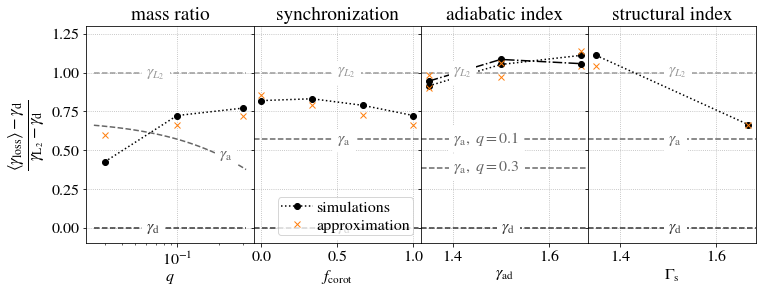

In [34]:
plt.figure(figsize=(12,4))

# Mass Ratio
plt.subplot(141)
plt.title('mass ratio')

ql = np.logspace(np.log10(0.025),-0.5,100)
gd = ql
ga = 1/ql
md = 1.
ma = ql
gl2 = (md+ma)**2/(md*ma)* 1.2**2

plt.plot(ql,(gd-gd)/(gl2-gd),'--',c='0.2',label="")
plt.plot(ql,(ga-gd)/(gl2-gd),'--',c='0.4',label="")
plt.plot(ql,(gl2-gd)/(gl2-gd),'--',c='0.6',label="")
plt.annotate(r'$\gamma_{\rm d}$',(0.06,-0.015),color='0.2',backgroundcolor='w')
plt.annotate(r'$\gamma_{\rm a}$',(0.2,0.45),color='0.4',backgroundcolor='w')
plt.annotate(r'$\gamma_{L_2}$',(0.06,0.975),color='0.6',backgroundcolor='w')

sel = (st['fcorot']==1) & (st['gamma_structure']==5./3.) & (st['a0']!=1.55)
plt.plot(st[sel][[1,0,2]]['m2'],(st[sel][[1,0,2]]['gl1']-st[sel][[1,0,2]]['gamma_d'])/(st[sel][[1,0,2]]['gamma_l2']-st[sel][[1,0,2]]['gamma_d']),'ko:',label='simulations')
plt.ylim(-0.1,1.3)
#plt.xlim(0,1/3.)
plt.grid(ls=":")
plt.xscale('log')
plt.xlabel(r'$q$')
plt.ylabel(r'$\frac{\langle \gamma_{\rm loss} \rangle - \gamma_{\rm d}}{\gamma_{\rm L_2} - \gamma_{\rm d}}$',fontsize=24)

plt.plot(st[sel]['m2'],st[sel]['gamma_loss_fit_norm'],'C1x')





# Synchronization
plt.subplot(142)
plt.title('synchronization')

md = 1.
ma = 0.1
gd = ma/md
ga = md/ma
gl2 = (md+ma)**2/(md*ma)* 1.2**2

plt.axhline((gd-gd)/(gl2-gd),ls='--',c='0.2')
plt.axhline((ga-gd)/(gl2-gd),ls='--',c='0.4')
plt.axhline((gl2-gd)/(gl2-gd),ls='--',c='0.6')
plt.annotate(r'$\gamma_{\rm d}$',(0.5,-0.015),color='0.2',backgroundcolor='w')
plt.annotate(r'$\gamma_{\rm a}$',(0.5,0.55),color='0.4',backgroundcolor='w')
plt.annotate(r'$\gamma_{L_2}$',(0.5,0.99),color='0.6',backgroundcolor='w')


sel = ((st['m2']==0.1) & (st['gamma_structure']==5./3.)  & (st['a0']!=1.55))
plt.plot(st[sel]['fcorot'],(st[sel]['gl1']-st[sel]['gamma_d'])/(st[sel]['gamma_l2']-st[sel]['gamma_d']),'ko:',label='simulations')
plt.ylim(-0.1,1.3)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r'$f_{\rm corot}$')

plt.plot(st[sel]['fcorot'],st[sel]['gamma_loss_fit_norm'],'C1x',label=r'approximation')
plt.legend(loc='lower right',frameon=True,fontsize=16)





# Adiabatic Index
plt.subplot(143)
plt.title('adiabatic index')


md = 1.
ma = 0.1
gd = ma/md
ga = md/ma
gl2 = (md+ma)**2/(md*ma)* 1.2**2

plt.axhline((gd-gd)/(gl2-gd),ls='--',c='0.2')
plt.axhline((ga-gd)/(gl2-gd),ls='--',c='0.4')
plt.axhline((gl2-gd)/(gl2-gd),ls='--',c='0.6')
plt.annotate(r'$\gamma_{\rm d}$',(1.5,-0.015),color='0.2',backgroundcolor='w')
plt.annotate(r'$\gamma_{\rm a}, \ q=0.1$',(1.4,0.55),color='0.4',backgroundcolor='w')
plt.annotate(r'$\gamma_{L_2}$',(1.4,0.99),color='0.6',backgroundcolor='w')

md = 1.
ma = 0.3
gd = ma/md
ga = md/ma
gl2 = (md+ma)**2/(md*ma)* 1.2**2

plt.axhline((ga-gd)/(gl2-gd),ls='--',c='0.4')
plt.annotate(r'$\gamma_{\rm a}, \ q=0.3$',(1.4,0.37),color='0.4',backgroundcolor='w')

sel = ( (st['m2']==0.1) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],(st[sel]['gl1']-st[sel]['gamma_d'])/(st[sel]['gamma_l2']-st[sel]['gamma_d']),'ko:',label='simulations')
plt.ylim(-0.1,1.3)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r"$\gamma_{\rm ad}$")

plt.plot(st[sel]['gamma_ad'],st[sel]['gamma_loss_fit_norm'],'C1x')

sel = ( (st['m2']==0.3) & (st['gamma_structure']==1.35) )
plt.plot(st[sel]['gamma_ad'],(st[sel]['gl1']-st[sel]['gamma_d'])/(st[sel]['gamma_l2']-st[sel]['gamma_d']),'ko-.',label='simulations')
plt.ylim(-0.1,1.3)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r"$\gamma_{\rm ad}$")

plt.plot(st[sel]['gamma_ad'],st[sel]['gamma_loss_fit_norm'],'C1x')

#plt.annotate(r"$q=0.3$",(1.42,1.7))
#plt.annotate(r"$q=0.1$",(1.45,0.47))


# Structural Index
plt.subplot(144)
plt.title('structural index')

md = 1.
ma = 0.1
gd = ma/md
ga = md/ma
gl2 = (md+ma)**2/(md*ma)* 1.2**2

plt.axhline((gd-gd)/(gl2-gd),ls='--',c='0.2')
plt.axhline((ga-gd)/(gl2-gd),ls='--',c='0.4')
plt.axhline((gl2-gd)/(gl2-gd),ls='--',c='0.6')
plt.annotate(r'$\gamma_{\rm d}$',(1.5,-0.015),color='0.2',backgroundcolor='w')
plt.annotate(r'$\gamma_{\rm a}$',(1.5,0.55),color='0.4',backgroundcolor='w')
plt.annotate(r'$\gamma_{L_2}$',(1.5,0.99),color='0.6',backgroundcolor='w')

sel = ((st['m2']==0.1) & (st['gamma_ad']==5./3.) & (st['fcorot']==1.0) & (st['a0']==1.55))
plt.plot(st[sel]['gamma_structure'],(st[sel]['gl1']-st[sel]['gamma_d'])/(st[sel]['gamma_l2']-st[sel]['gamma_d']),'ko:',label='simulations')
plt.ylim(-0.1,1.3)
plt.yticks(visible=False)
plt.grid(ls=":")
plt.xlabel(r"$\Gamma_{\rm s}$")

plt.plot(st[sel]['gamma_structure'],st[sel]['gamma_loss_fit_norm'],'C1x')

plt.subplots_adjust(wspace=0)

plt.savefig("../figures/gamma_loss_variations.pdf",bbox_inches='tight')

# Fig 6: a(t) and Ndecay(t)

In [35]:
def make_sep_plot_onepanel(base_dir,color='red',label=""):
    orb = ou.read_trackfile(base_dir+'pm_trackfile.dat')
    #t1 = ou.get_t1(orb)
    hst = read_hst(base_dir+"HSE.hst",orb)
    
    orb['M1'] = np.interp(orb['time'],hst['time'],hst['M1'])
    orb['a'] = -0.5*orb['M1']*orb['m2']/orb['Eorb']
    
    sel = orb['time']>0.0
    plt.plot(orb[sel]['time'],orb[sel]['a'],color=color ,label=label,lw=2)
    
    plt.grid(ls=':')
    plt.yticks(visible=False)
    plt.xlabel(r'time $[t_{\rm dyn,1}]$')
    plt.ylim(1,2.25)
    
    plt.subplots_adjust(wspace=0)
    return


reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...


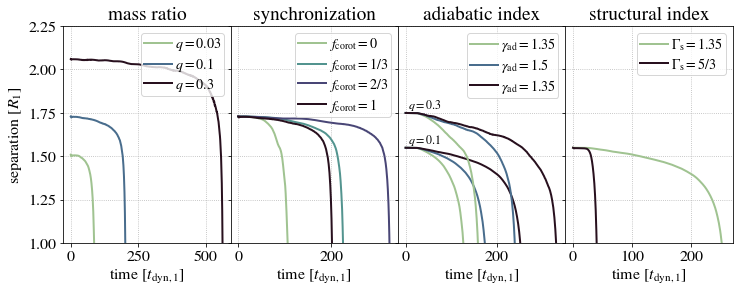

In [36]:
plt.figure(figsize=(12,4))

# Mass Ratio
plt.subplot(141)
plt.title('mass ratio')
pal=sns.cubehelix_palette(3,start=0.9, rot=-1,light=0.7,dark=.1)
make_sep_plot_onepanel("../data/mass_ratio/fc10/q003/",
                        label=r'$q=0.03$',color=pal[0])
make_sep_plot_onepanel("../data/synchronization/q01/fc10/",
                        label=r'$q=0.1$',color=pal[1])
make_sep_plot_onepanel("../data/mass_ratio/fc10/q03/",
                        label=r'$q=0.3$',color=pal[2])
plt.legend(loc='upper right',frameon=True)
plt.yticks(visible=True)
plt.ylabel(r"separation $[R_1]$")

# Synchronization
plt.subplot(142)
plt.title('synchronization')
pal=sns.cubehelix_palette(4,start=0.9, rot=-1,light=0.7,dark=.1)
make_sep_plot_onepanel("../data/synchronization/q01/fc0/",
              label=r'$f_{\rm corot}=0$',color=pal[0])
make_sep_plot_onepanel("../data/synchronization/q01/fc033/",
               label=r'$f_{\rm corot}=1/3$',color=pal[1])
make_sep_plot_onepanel("../data/synchronization/q01/fc066/",
               label=r'$f_{\rm corot}=2/3$',color=pal[2])
make_sep_plot_onepanel("../data/synchronization/q01/fc10/",
               label=r'$f_{\rm corot}=1$',color=pal[3])
plt.legend(loc='upper right',frameon=True)


# Adiabatic Index
plt.subplot(143)
plt.title('adiabatic index')
pal=sns.cubehelix_palette(3,start=0.9, rot=-1,light=0.7,dark=.1)
make_sep_plot_onepanel("../data/structure_43/q01/a15/gs43_ga43/",
                        label=r'$\gamma_{\rm ad}=1.35$',color=pal[0])
make_sep_plot_onepanel("../data/structure_43/q01/a15/gs43_ga15/",
                        label=r'$\gamma_{\rm ad}=1.5$',color=pal[1])
make_sep_plot_onepanel("../data/structure_43/q01/a15/gs43_ga53/",
                        label=r'$\gamma_{\rm ad}=1.35$',color=pal[2])
plt.legend(loc='upper right',frameon=True)

make_sep_plot_onepanel("../data/structure_43/q03/gs43_ga43/",
                        label=r'$\gamma_{\rm ad}=1.35$',color=pal[0])
make_sep_plot_onepanel("../data/structure_43/q03/gs43_ga15/",
                        label=r'$\gamma_{\rm ad}=1.5$',color=pal[1])
make_sep_plot_onepanel("../data/structure_43/q03/gs43_ga53/",
                        label=r'$\gamma_{\rm ad}=5/3$',color=pal[2])

plt.annotate(r"$q=0.3$",(5,1.775),fontsize=12)
plt.annotate(r"$q=0.1$",(5,1.575),fontsize=12)

# Structural Index
plt.subplot(144)
plt.title('structural index')
pal=sns.cubehelix_palette(2,start=0.9, rot=-1,light=0.7,dark=.1)
make_sep_plot_onepanel("../data/structure_43/q01/a15/gs43_ga53/",
                         label=r'$\Gamma_{\rm s}=1.35$',color=pal[0])
make_sep_plot_onepanel("../data/separation/q01/a17/",
                         label=r'$\Gamma_{\rm s}=5/3$',color=pal[1])
plt.legend(loc='upper right',frameon=True)

plt.savefig("../figures/orb_sep_time_variations.pdf",bbox_inches='tight')

In [37]:
def make_ndecay_onepanel(base_dir,color='red',label="",skip=1):
    orb = ou.read_trackfile(base_dir+'pm_trackfile.dat')
    hst = read_hst(base_dir+"HSE.hst",orb)
    
    orb['M1'] = np.interp(orb['time'],hst['time'],hst['M1'])
    orb['a'] = -0.5*orb['M1']*orb['m2']/orb['Eorb']
    orb['P'] = 2*np.pi*np.sqrt(orb['a']**3 / (orb['M1']+orb['m2']))
    pdot = np.gradient(orb[::skip]['P'])/np.gradient(orb[::skip]['time'])
    
    pdotsmooth = convolve(pdot,Box1DKernel(10),boundary='extend')  # 1 tdyn
    select = orb[::skip]['a']>0.75*a_RL(orb['m2'][0])
    pdotsmooth[select] = convolve(pdotsmooth[select],Box1DKernel(10),boundary='extend') # 3 tdyn
    select = orb[::skip]['a']>0.9*a_RL(orb['m2'][0])
    pdotsmooth[select] = convolve(pdotsmooth[select],Box1DKernel(1000),boundary='extend') # 10 tdyn
    
    
    #plt.plot(orb[::skip]['sep'],np.abs(1/pdot),color='0.8',label=label,lw=2)
    plt.plot(orb[::skip]['a'],np.abs(1/pdotsmooth),color=color ,label=label,lw=2)
    
    plt.grid(ls=':')
    plt.yticks(visible=False)
    plt.ylim(1,1.e3)
    plt.yscale('log')
    plt.xlabel('separation $[R_1]$')
    plt.xticks([1.2,1.4,1.6,1.8,2.,2.2])
    plt.xlim(1,orb['sep'][0])
    
    plt.subplots_adjust(wspace=0)
    return

reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...
reading orbit file for binary simulation...


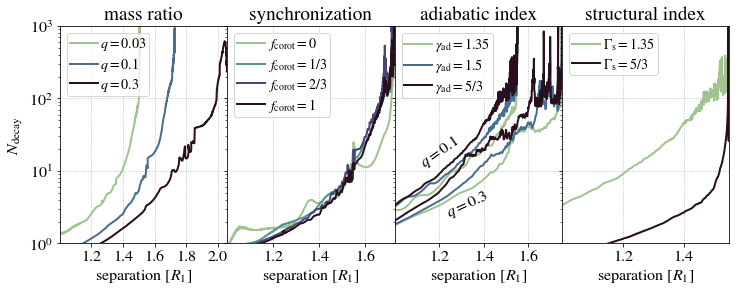

In [38]:
plt.figure(figsize=(12,4))

# Mass Ratio
plt.subplot(141)
plt.title('mass ratio')
pal=sns.cubehelix_palette(3,start=0.9, rot=-1,light=0.7,dark=.1)
make_ndecay_onepanel("../data/mass_ratio/fc10/q003/",
                        label=r'$q=0.03$',color=pal[0])
make_ndecay_onepanel("../data/synchronization/q01/fc10/",
                        label=r'$q=0.1$',color=pal[1],skip=5)
make_ndecay_onepanel("../data/mass_ratio/fc10/q03/",
                        label=r'$q=0.3$',color=pal[2],skip=30)
plt.legend(loc='upper left',frameon=True)
plt.yticks(visible=True)
plt.ylabel(r"$N_{\rm decay}$")

# Synchronization
plt.subplot(142)
plt.title('synchronization')
pal=sns.cubehelix_palette(4,start=0.9, rot=-1,light=0.7,dark=.1)
make_ndecay_onepanel("../data/synchronization/q01/fc0/",
              label=r'$f_{\rm corot}=0$',color=pal[0])
make_ndecay_onepanel("../data/synchronization/q01/fc033/",
               label=r'$f_{\rm corot}=1/3$',color=pal[1])
make_ndecay_onepanel("../data/synchronization/q01/fc066/",
               label=r'$f_{\rm corot}=2/3$',color=pal[2])
make_ndecay_onepanel("../data/synchronization/q01/fc10/",
               label=r'$f_{\rm corot}=1$',color=pal[3])
plt.legend(loc='upper left',frameon=True)


# Adiabatic Index
plt.subplot(143)
plt.title('adiabatic index')
pal=sns.cubehelix_palette(3,start=0.9, rot=-1,light=0.7,dark=.1)
make_ndecay_onepanel("../data/structure_43/q01/a15/gs43_ga43/",
                        label=r'$\gamma_{\rm ad}=1.35$',color=pal[0],skip=10)
make_ndecay_onepanel("../data/structure_43/q01/a15/gs43_ga15/",
                        label=r'$\gamma_{\rm ad}=1.5$',color=pal[1],skip=10)
make_ndecay_onepanel("../data/structure_43/q01/a15/gs43_ga53/",
                        label=r'$\gamma_{\rm ad}=5/3$',color=pal[2],skip=10)
plt.legend(loc='upper left',frameon=True)

make_ndecay_onepanel("../data/structure_43/q03/gs43_ga43/",
                        label=r'$\gamma_{\rm ad}=1.35$',color=pal[0],skip=30)
make_ndecay_onepanel("../data/structure_43/q03/gs43_ga15/",
                        label=r'$\gamma_{\rm ad}=1.5$',color=pal[1],skip=30)
make_ndecay_onepanel("../data/structure_43/q03/gs43_ga53/",
                        label=r'$\gamma_{\rm ad}=5/3$',color=pal[2],skip=30)

plt.annotate(r"$q=0.1$",(1.1,23),Rotation=35)
plt.annotate(r"$q=0.3$",(1.22,4),Rotation=25)

# Structural Index
plt.subplot(144)
plt.title('structural index')
pal=sns.cubehelix_palette(2,start=0.9, rot=-1,light=0.7,dark=.1)
make_ndecay_onepanel("../data/structure_43/q01/a15/gs43_ga53/",
                         label=r'$\Gamma_{\rm s}=1.35$',color=pal[0],skip=10)
make_ndecay_onepanel("../data/separation/q01/a17/",
                         label=r'$\Gamma_{\rm s}=5/3$',color=pal[1])
plt.legend(loc='upper left',frameon=True)

plt.savefig("../figures/orb_ndecay_variations.pdf",bbox_inches='tight')

# Figures 7 and 8: simulation comparisons

In [42]:
import sys
sys.path.append('../../RLOF/src')
import rlof

reload(rlof)


from scipy.interpolate import interp1d

# COmputed in Polytropic_Envelope.ipynb
mr43_43 = ascii.read('../data/mass_radius/mass_radius_43_43.dat')
mr43_15 = ascii.read('../data/mass_radius/mass_radius_43_15.dat')
mr43_53 = ascii.read('../data/mass_radius/mass_radius_43_53.dat')
mr53_53 = ascii.read('../data/mass_radius/mass_radius_53_53.dat')

# Interpolating functions
R53_53 = interp1d(mr53_53['m']/mr53_53['m'][0],mr53_53['r']/mr53_53['r'][0],bounds_error=False,fill_value="extrapolate")
R43_53 = interp1d(mr43_53['m']/mr43_53['m'][0],mr43_53['r']/mr43_53['r'][0],bounds_error=False,fill_value="extrapolate")
R43_15 = interp1d(mr43_15['m']/mr43_15['m'][0],mr43_15['r']/mr43_15['r'][0],bounds_error=False,fill_value="extrapolate")
R43_43 = interp1d(mr43_43['m']/mr43_43['m'][0],mr43_43['r']/mr43_43['r'][0],bounds_error=False,fill_value="extrapolate")


st = ascii.read("../data/summary_table/sim_table_bu.dat")

In [45]:
def make_double_plot(sol,sol_acc,sol_L2,orb,hst,tstart,t1):
    plt.figure(figsize=(5,5))
    plt.subplot(211)
    plt.plot(sol['t'],sol['a'],c='C1',ls='-',label=r'analytic: $\gamma_{\rm loss}=\langle\gamma_{\rm loss}\rangle$')
    plt.plot(orb['time']-tstart,orb['a'],'k-',lw=3,label=r'simulation')
    plt.legend(frameon=True,fontsize=12)

    plt.xlim(0,)
    plt.ylim(1,orb['sep'][0]+0.1)
    plt.xticks(visible=False)
    plt.ylabel(r'separation $[R_1]$')

    plt.subplot(212)
    plt.plot(sol['t'],-sol['dMddt'],c='C1',ls='-',label=r'analytic: $\gamma_{\rm loss}=\langle\gamma_{\rm loss}\rangle$')
    plt.plot(hst['time']-tstart,-hst['mdotsmooth'],'k-',lw=3,label=r'simulation')

    plt.xlim(0,)
    plt.yscale('log')
    plt.ylim(1.e-6,3.e-2)
    plt.xlabel(r'time (arb. offset)  $[t_{\rm dyn,1}]$')
    plt.ylabel(r'$|\dot M_{\rm d}| \ \ [M_1/t_{\rm dyn,1}]$')

    plt.subplots_adjust(hspace=0)
    
    
def setup_and_integrate(mydir,tstart_m_t1,tmax=2.e3,radius_factor=1.):
    orb = ou.read_trackfile(mydir + "pm_trackfile.dat")
    t1 = ou.get_t1(orb)
    hst = read_hst(mydir+"HSE.hst",orb)
    
    orb['M1'] = np.interp(orb['time'],hst['time'],hst['M1'])
    orb['a'] = -0.5*orb['M1']*orb['m2']/orb['Eorb']

    tstart = t1+tstart_m_t1
    astart = np.interp(tstart,orb['time'],orb['sep'])
    mstart = np.interp(tstart,hst['time'],hst['M1'])
    
    Rdrot = st[ st['dir']==root_dir_morgan+mydir[8:] ]['Rd_rot'][0]
    gamma_s = st[ st['dir']==root_dir_morgan+mydir[8:] ]['gamma_structure'][0]
    gamma_ad = st[ st['dir']==root_dir_morgan+mydir[8:] ]['gamma_ad'][0]
    fcorot = st[ st['dir']==root_dir_morgan+mydir[8:] ]['fcorot'][0]
    
    if((gamma_s==5./3.) & (gamma_ad==5./3.)):
        Rdfunc = R53_53
        mrtab = mr53_53
    if((gamma_s==1.35) & (gamma_ad==5./3.)):
        Rdfunc = R43_53
        mrtab = mr43_53
    if((gamma_s==1.35) & (gamma_ad==1.5)):
        Rdfunc = R43_15
        mrtab = mr43_15
    if((gamma_s==1.35) & (gamma_ad==1.35)):
        Rdfunc = R43_43
        mrtab = mr43_43
    
    r=rlof.RLOF(Md0=mstart,
                Mdtot = mrtab['m'][0],
             Ma0=orb['m2'][0],
             Rd0=radius_factor*Rdrot,
             Ra0=0.0,
             Ggrav=1,
             a0_mode='manual',
             a0 = astart,
             gamma_adiabatic=gamma_ad,
             gamma_structure=gamma_s,
             fcorot0=fcorot,
             Rdfunc=Rdfunc,  
             amin_integrate=1.)

    sol_acc = r.integrate(tmax,Ntimes=10001,loss_mode='accretor',mdot_mode='simulation',rtol=1.e-12)
    sol = r.integrate(tmax,Ntimes=10001,loss_mode='simulation',mdot_mode='simulation',rtol=1.e-12)
    sol_L2 = r.integrate(tmax,Ntimes=10001,loss_mode='l2',mdot_mode='simulation',rtol=1.e-12)

    make_double_plot(sol,sol_acc,sol_L2,orb,hst,tstart,t1)

reading orbit file for binary simulation...
=== RLOF: binary defined =======
('Md0 = ', 0.9980512587224167)
('Ma0 = ', 0.1)
('Rd0 = ', 1.0445618208485448)
('Ra0 = ', 0.0)
('a0 = ', 1.7052879185899361)
('G = ', 1)
----------donor star------------
('Md0 = ', 0.9980512587224167)
('Md(original) = ', 1.0000288166897433)
('Rd0 = ', 1.0445618208485448)
('Rdfunc = ', <scipy.interpolate.interpolate.interp1d object at 0x124dc9158>)
('fcorot0 = ', 1.0)
('gamma_adiabatic = ', 1.6666666666666667)
('gamma_structure = ', 1.6666666666666667)
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([205.87652533])])
--------------------------------
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([176.64528568])])
--------------------------------
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([114.69367264])])
---------------------------

/Users/morganmacleod/CODE/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


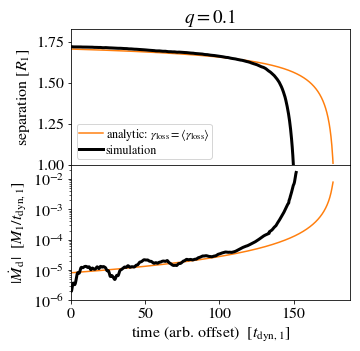

In [48]:
mydir = '../data/synchronization/q01/fc10/'
setup_and_integrate(mydir,-150)

plt.subplot(211)
plt.title(r"$q=0.1$")

plt.savefig("../figures/reconstruct_q01.pdf",bbox_inches='tight')

reading orbit file for binary simulation...
=== RLOF: binary defined =======
('Md0 = ', 0.9968891813914794)
('Ma0 = ', 0.3)
('Rd0 = ', 1.0329236252621619)
('Ra0 = ', 0.0)
('a0 = ', 2.017276304397877)
('G = ', 1)
----------donor star------------
('Md0 = ', 0.9968891813914794)
('Md(original) = ', 1.0000288166897433)
('Rd0 = ', 1.0329236252621619)
('Rdfunc = ', <scipy.interpolate.interpolate.interp1d object at 0x124dc9158>)
('fcorot0 = ', 1.0)
('gamma_adiabatic = ', 1.6666666666666667)
('gamma_structure = ', 1.6666666666666667)
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([598.48215854])])
--------------------------------
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([289.74439913])])
--------------------------------
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([203.08865168])])
----------------------------

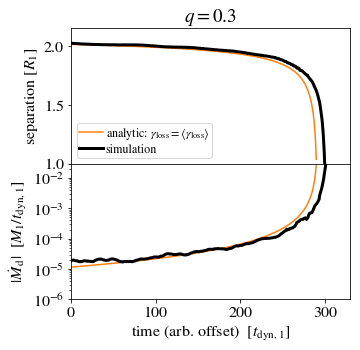

In [49]:
mydir = '../data/mass_ratio/fc10/q03/'
setup_and_integrate(mydir,-300)
plt.subplot(211)
plt.title(r"$q=0.3$")

plt.savefig("../figures/reconstruct_q03.pdf",bbox_inches='tight')

reading orbit file for binary simulation...
=== RLOF: binary defined =======
('Md0 = ', 0.9990623724753227)
('Ma0 = ', 0.1)
('Rd0 = ', 1.0070983768980108)
('Ra0 = ', 0.0)
('a0 = ', 1.7021085674652443)
('G = ', 1)
----------donor star------------
('Md0 = ', 0.9990623724753227)
('Md(original) = ', 1.0000288166897433)
('Rd0 = ', 1.0070983768980108)
('Rdfunc = ', <scipy.interpolate.interpolate.interp1d object at 0x124dc9158>)
('fcorot0 = ', 0.0)
('gamma_adiabatic = ', 1.6666666666666667)
('gamma_structure = ', 1.6666666666666667)
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([648.79953904])])
--------------------------------
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([423.48960376])])
--------------------------------
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([361.41560796])])
---------------------------

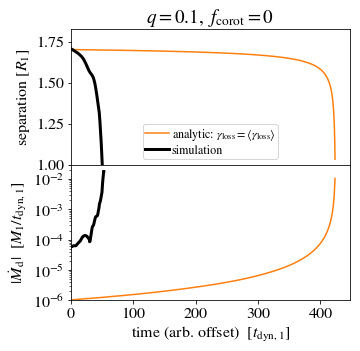

In [50]:
mydir = '../data/synchronization/q01/fc0/'
setup_and_integrate(mydir,-50, radius_factor=1)

plt.subplot(211)
plt.title(r"$q=0.1, \  f_{\rm corot}=0$")

plt.savefig("../figures/reconstruct_fc0.pdf",bbox_inches='tight')

reading orbit file for binary simulation...
=== RLOF: binary defined =======
('Md0 = ', 0.9990623724753227)
('Ma0 = ', 0.1)
('Rd0 = ', 1.0675242795118915)
('Ra0 = ', 0.0)
('a0 = ', 1.7021085674652443)
('G = ', 1)
----------donor star------------
('Md0 = ', 0.9990623724753227)
('Md(original) = ', 1.0000288166897433)
('Rd0 = ', 1.0675242795118915)
('Rdfunc = ', <scipy.interpolate.interpolate.interp1d object at 0x124dc9158>)
('fcorot0 = ', 0.0)
('gamma_adiabatic = ', 1.6666666666666667)
('gamma_structure = ', 1.6666666666666667)
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([55.9690004])])
--------------------------------
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([36.50713627])])
--------------------------------
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([31.15961336])])
-------------------------------

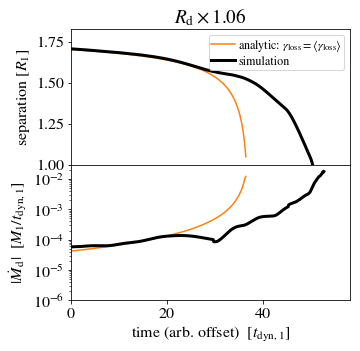

In [51]:
mydir = '../data/synchronization/q01/fc0/'
setup_and_integrate(mydir,-50, radius_factor=1.06)

plt.subplot(211)
plt.title(r"$R_{\rm d} \times 1.06$")

plt.savefig("../figures/reconstruct_fc0_Rd.pdf",bbox_inches='tight')

# Fig 9: v1309 Sco

In [52]:
# initial conditions
ty = ascii.read("../data/binary_obsv/v1309_tylenda_period_data.dat")
ty['yr'] = (ty['JD'] - ty['JD'][0])/365.25
molnar = ascii.read("../data/binary_obsv/v1309_molnar_period_data.dat")

from astropy.time import Time
molnar['jd'] = Time(molnar['year'],format='decimalyear').jd

jdpeak = Time('2008-09-06').jd


pejcha = ascii.read("../data/binary_obsv/PejchaMdot_jd.csv",names=['orb_pre_merger','log_mdot'])
pejcha['jd']=jdpeak - pejcha['orb_pre_merger']*ty['p'][0]

=== RLOF: binary defined =======
('Md0 = ', 2.9835e+33)
('Ma0 = ', 2.9835e+32)
('Rd0 = ', 256095931975.0)
('Ra0 = ', 0.0)
('a0 = ', 440686210819.3699)
('G = ', 6.674e-08)
----------donor star------------
('Md0 = ', 2.9835e+33)
('Md(original) = ', 2.9835e+33)
('Rd0 = ', 256095931975.0)
('Rdfunc = ', <bound method RLOF.Rdfunc_constant of <rlof.RLOF instance at 0x12fae6680>>)
('fcorot0 = ', 1.0)
('gamma_adiabatic = ', 1.6666666666666667)
('gamma_structure = ', 1.6666666666666667)
---- integration ---------------
('solver message: ', 'A termination event occurred.')
('events: ', [array([1.93234185e+08])])
--------------------------------
['t', 'Md', 'Rd', 'Ma', 'Ra', 'a', 'dMddt', 'jd']
=== RLOF: binary defined =======
('Md0 = ', 2.9835e+33)
('Ma0 = ', 2.9835e+32)
('Rd0 = ', 255842909075.0)
('Ra0 = ', 0.0)
('a0 = ', 440686210819.3699)
('G = ', 6.674e-08)
----------donor star------------
('Md0 = ', 2.9835e+33)
('Md(original) = ', 2.9835e+33)
('Rd0 = ', 255842909075.0)
('Rdfunc = ', <bound m

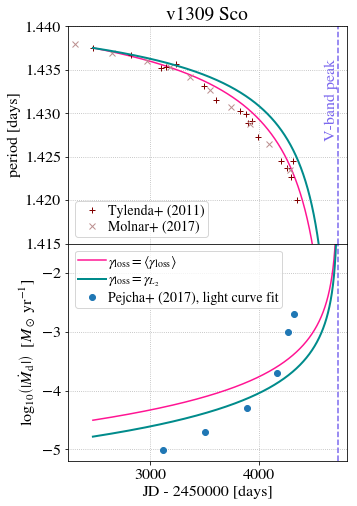

In [53]:
r=rlof.RLOF(Md0=1.5*c.msun,
         Ma0=0.15*c.msun,
         Rd0=3.6821845*c.rsun,
         Ra0=0.0,
         Ggrav=6.674e-8,
         a0_mode='period',
         P0 = 1.4375*86400.0,
         gamma_adiabatic=5./3.,
         gamma_structure=5./3.,
         fcorot0=1.0,
         Rdfunc=None)

sol = r.integrate(7*c.yr,Ntimes=100001,loss_mode='simulation',mdot_mode='simulation',rtol=1.e-12)

sol['jd']=sol['t']/(24*3600.)+ty['JD'][0]

print(sol.keys())


simc ='DeepPink'
l2c = 'DarkCyan'

plt.figure(figsize=(5,8))
plt.subplot(211)
plt.plot(sol['jd']-2450000, 2*np.pi*np.sqrt(sol['a']**3 / (c.G*(sol['Md']+sol['Ma'])))/86400.,label='',color=simc)
plt.ylabel('period [days]')
plt.plot(ty['JD']-2450000,ty['p'],'+',color='Maroon',label='Tylenda+ (2011)')
plt.plot(molnar['jd']-2450000,molnar['p'],'x',color='RosyBrown',label='Molnar+ (2017)')
plt.ylim(1.415,1.44)
plt.xticks(visible=False)
plt.grid(ls=':')
plt.legend(loc=0,frameon=True)


plt.subplot(212)
plt.plot(sol['jd']-2450000, 
         np.log10(np.gradient(-sol['Md'])/np.gradient(sol['t']) / (c.msun/c.yr) ),label=r'$\gamma_{\rm loss}= \langle \gamma_{\rm loss}\rangle$',
        color=simc)
plt.xlabel('JD - 2450000 [days]')
plt.ylabel(r'$\log_{10}\left( |\dot  M_{\rm d}|  \right) \ \ [M_\odot \ {\rm yr}^{-1}] $')
plt.grid(ls=':')




r=rlof.RLOF(Md0=1.5*c.msun,
         Ma0=0.15*c.msun,
         Rd0=3.6785465*c.rsun,
         Ra0=0.0,
         Ggrav=6.674e-8,
         a0_mode='period',
         P0 = 1.4375*86400.0,
         gamma_adiabatic=5./3.,
         gamma_structure=5./3.,
         fcorot0=1.0,
         Rdfunc=None)

sol = r.integrate(7*c.yr,Ntimes=100001,loss_mode='l2',mdot_mode='simulation',rtol=1.e-12)
sol['jd']=sol['t']/(24*3600.)+ty['JD'][0]

print(sol.keys())


#plt.figure(figsize=(5,8))
plt.subplot(211)
plt.plot(sol['jd']-2450000, 2*np.pi*np.sqrt(sol['a']**3 / (c.G*(sol['Md']+sol['Ma'])))/86400.,color=l2c,lw=2)

plt.subplot(212)
plt.plot(sol['jd']-2450000, 
         np.log10(np.gradient(-sol['Md'])/np.gradient(sol['t']) / (c.msun/c.yr) ) ,label=r'$\gamma_{\rm loss}= \gamma_{L_2}$',color=l2c,lw=2)

plt.subplots_adjust(hspace=0)
plt.legend(loc=0,frameon=True,fontsize=16)

plt.subplot(211)
plt.axvline(jdpeak-2450000,ls='--',color='MediumSlateBlue')
plt.annotate('V-band peak',(jdpeak-2450000-120,1.435),Rotation=90,color='MediumSlateBlue')
plt.xlim(2250,4800)
plt.title("v1309 Sco")

plt.subplot(212)
plt.axvline(jdpeak-2450000,ls='--',color='MediumSlateBlue')
plt.xlim(2250,4800)
plt.ylim(-5.2,-1.5)
plt.plot(pejcha['jd']-2450000,pejcha['log_mdot'],"o",label='Pejcha+ (2017), light curve fit')
plt.legend(loc=0,frameon=True)


plt.savefig('../figures/v1309Sco.pdf',bbox_inches='tight')

In [54]:
(jdpeak - ty['JD'][0])*86400

193231755.89787215

# Fig 10: N-N plane

In [55]:
molnarKIC = ascii.read("../data/binary_obsv/KIC_molnar_period_data.dat")
molnarKIC['pdot'] = np.gradient(molnarKIC['p']*24*3600)/np.gradient(molnarKIC['yr']*c.yr)
molnarKIC['pddot'] = np.gradient(molnarKIC['pdot'])/np.gradient(molnarKIC['yr']*c.yr)

molnar = ascii.read("../data/binary_obsv/v1309_molnar_period_data.dat")
molnar['pdot'] = np.gradient(molnar['p']*24*3600)/np.gradient(molnar['yr']*c.yr)
molnar['pddot'] = np.gradient(molnar['pdot'])/np.gradient(molnar['yr']*c.yr)

ty = ascii.read("../data/binary_obsv/v1309_tylenda_period_data.dat")
ty['pdot'] = np.gradient(ty['p']*86400)/np.gradient(ty['JD']*86400.)
ty['pddot'] = np.gradient(ty['pdot'])/np.gradient(ty['JD']*86400.)

In [56]:
molnarKIC["Pdot_err"]  = np.sqrt(np.sum((molnarKIC['sigma']*86400.)**2))/np.gradient(molnarKIC['yr']*c.yr)
molnarKIC['Pddot_err'] = np.sqrt(3*molnarKIC["Pdot_err"]**2)/np.gradient(molnarKIC['yr']*c.yr)
molnarKIC['Ndecay'] = 1/np.abs(molnarKIC['pdot'])
molnarKIC['Naccel'] = np.abs(molnarKIC['pdot']/molnarKIC['pddot'])/(molnarKIC['p']*86400) 
molnarKIC['Ndecay_err'] = molnarKIC['Ndecay'] * np.sqrt( (molnarKIC["Pdot_err"]/molnarKIC['pdot'])**2 )
molnarKIC['Naccel_err'] = (molnarKIC['Naccel']
                           * np.sqrt((molnarKIC["Pdot_err"]/molnarKIC['pdot'])**2 
                           + (molnarKIC["Pddot_err"]/molnarKIC['pddot'])**2 
                           + (molnarKIC['sigma']/molnarKIC['p'])**2 ) )

In [57]:
molnar['sigma'] = 1.e-6 * 1.42
molnar["Pdot_err"]  = np.sqrt(np.sum((molnar['sigma']*86400.)**2))/np.gradient(molnar['yr']*c.yr)
molnar['Pddot_err'] = np.sqrt(3*molnar["Pdot_err"]**2)/np.gradient(molnar['yr']*c.yr)
molnar['Ndecay'] = 1/np.abs(molnar['pdot'])
molnar['Naccel'] = np.abs(molnar['pdot']/molnar['pddot'])/(molnar['p']*86400) 
molnar['Ndecay_err'] = molnar['Ndecay'] * np.sqrt( (molnar["Pdot_err"]/molnar['pdot'])**2 )
molnar['Naccel_err'] = (molnar['Naccel']
                           * np.sqrt((molnar["Pdot_err"]/molnar['pdot'])**2 
                           + (molnar["Pddot_err"]/molnar['pddot'])**2 
                           + (molnar['sigma']/molnar['p'])**2 ) )

=== RLOF: binary defined =======
('Md0 = ', 2.774655e+33)
('Ma0 = ', 6.32502e+32)
('Rd0 = ', 106084615000.0)
('Ra0 = ', 0.0)
('a0 = ', 208143542263.027)
('G = ', 6.674e-08)
----------donor star------------
('Md0 = ', 2.774655e+33)
('Md(original) = ', 2.774655e+33)
('Rd0 = ', 106084615000.0)
('Rdfunc = ', <bound method RLOF.Rdfunc_constant of <rlof.RLOF instance at 0x11dd95758>>)
('fcorot0 = ', 1.0)
('gamma_adiabatic = ', 1.6666666666666667)
('gamma_structure = ', 1.6666666666666667)
---- integration ---------------
('solver message: ', 'Required step size is less than spacing between numbers.')
('events: ', [array([], dtype=float64)])
--------------------------------
=== RLOF: binary defined =======
('Md0 = ', 2.9835e+33)
('Ma0 = ', 2.9835e+32)
('Rd0 = ', 256117318600.0)
('Ra0 = ', 0.0)
('a0 = ', 440686210819.3699)
('G = ', 6.674e-08)
----------donor star------------
('Md0 = ', 2.9835e+33)
('Md(original) = ', 2.9835e+33)
('Rd0 = ', 256117318600.0)
('Rdfunc = ', <bound method RLOF.Rdfun

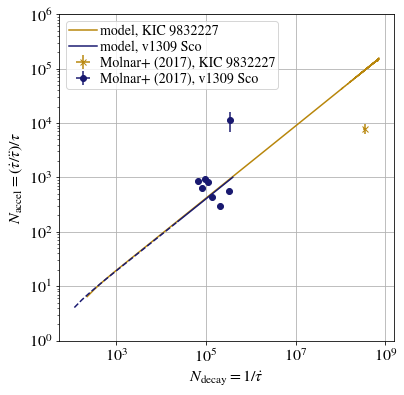

In [58]:
v1309c = 'MidnightBlue'
KICc = 'DarkGoldenrod'

plt.figure(figsize=(6,6))

start=3
end=-3



# KIC 
r=rlof.RLOF(Md0=1.395*c.msun,
         Ma0=0.318*c.msun,
         Rd0=1.5253*c.rsun,
         Ra0=0.0,
         Ggrav=6.674e-8,
         a0_mode='period',
         P0 = molnarKIC['p'][0]*86400.0,
         gamma_adiabatic=5./3.,
         gamma_structure=5./3.,
         fcorot0=1.0,
         Rdfunc=None)

sol = r.integrate(350*c.yr,Ntimes=100001,loss_mode='simulation',mdot_mode='simulation',rtol=1.e-12)
sol['P'] = 2*np.pi*np.sqrt(sol['a']**3/(6.674e-8*(sol['Md']+sol['Ma'])) )
sol['Pdot'] = np.gradient(sol['P'])/np.gradient(sol['t'])
sol['Pddot'] = np.gradient(sol['Pdot'])/np.gradient(sol['t'])

sel=sol['P']>0.
plt.plot(1/np.abs(sol[sel][start:end]["Pdot"]),np.abs(sol[sel][start:end]["Pdot"]/sol[sel][start:end]["Pddot"])/sol[sel][start:end]["P"],
         color=KICc,ls='-',label='model, KIC 9832227')

# V1309 Sco
r=rlof.RLOF(Md0=1.5*c.msun,
         Ma0=0.15*c.msun,
         Rd0=3.682492*c.rsun,
         Ra0=0.0,
         Ggrav=6.674e-8,
         a0_mode='period',
         P0 = 1.4375*86400.0,
         gamma_adiabatic=5./3.,
         gamma_structure=5./3.,
         fcorot0=1.0,
         Rdfunc=None)

sol = r.integrate(7*c.yr,Ntimes=1001,loss_mode='simulation',mdot_mode='simulation',rtol=1.e-12)

sol['P'] = 2*np.pi*np.sqrt(sol['a']**3/(6.674e-8*(sol['Md']+sol['Ma'])) )
sol['Pdot'] = np.gradient(sol['P'])/np.gradient(sol['t'])
sol['Pddot'] = np.gradient(sol['Pdot'])/np.gradient(sol['t'])

sel=sol['P']<1.42*86400.
plt.plot(1/np.abs(sol[sel][start:end]["Pdot"]),np.abs(sol[sel][start:end]["Pdot"]/sol[sel][start:end]["Pddot"])/sol[sel][start:end]["P"],
         color=v1309c,ls='--',label='')
sel=sol['P']>1.42*86400.
plt.plot(1/np.abs(sol[sel][start:end]["Pdot"]),np.abs(sol[sel][start:end]["Pdot"]/sol[sel][start:end]["Pddot"])/sol[sel][start:end]["P"],
         color=v1309c,ls='-',label='model, v1309 Sco')



# DATA 
#plt.plot(1/np.abs(ty['pdot']),np.abs(ty['pdot']/ty['pddot'])/(ty['p']*86400),'*',
#         label='Tylenda+ (2011), v1309 Sco')
plt.errorbar(molnarKIC[1:-1]['Ndecay'],molnarKIC[1:-1]['Naccel'],
             yerr=molnarKIC[1:-1]['Naccel_err'],xerr=molnarKIC[1:-1]["Ndecay_err"],fmt='x',
         label='Molnar+ (2017), KIC 9832227',color=KICc)
plt.errorbar(molnar[1:-1]['Ndecay'],molnar[1:-1]['Naccel'],molnar[1:-1]["Naccel_err"],molnar[1:-1]['Ndecay_err'],fmt='o',
         label='Molnar+ (2017), v1309 Sco',color=v1309c)



plt.loglog()
plt.legend(loc='upper left',frameon=True)
plt.xlabel(r'$N_{\rm decay} = 1/\dot \tau$')
plt.ylabel(r'$N_{\rm accel} = (\dot \tau / \ddot \tau) / \tau $')
plt.ylim(1.,1.e6)
plt.grid()
plt.savefig("../figures/v1309_KIC_NdecayNaccel.pdf",bbox_inches='tight')

=== RLOF: binary defined =======
('Md0 = ', 2.774655e+33)
('Ma0 = ', 6.32502e+32)
('Rd0 = ', 106084615000.0)
('Ra0 = ', 0.0)
('a0 = ', 208143542263.027)
('G = ', 6.674e-08)
----------donor star------------
('Md0 = ', 2.774655e+33)
('Md(original) = ', 2.774655e+33)
('Rd0 = ', 106084615000.0)
('Rdfunc = ', <bound method RLOF.Rdfunc_constant of <rlof.RLOF instance at 0x125872ea8>>)
('fcorot0 = ', 1.0)
('gamma_adiabatic = ', 1.6666666666666667)
('gamma_structure = ', 1.6666666666666667)
---- integration ---------------
('solver message: ', 'Required step size is less than spacing between numbers.')
('events: ', [array([], dtype=float64)])
--------------------------------
Model: Linear1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
          slope             intercept     
    ------------------ -------------------
    0.6661456414287529 -1.6436084423083857


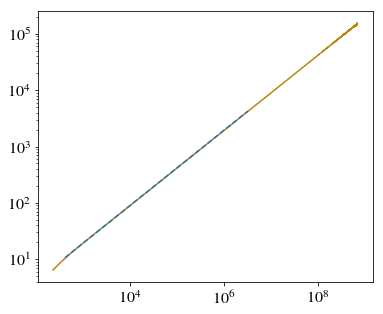

In [59]:
from astropy.modeling import models, fitting

# KIC 
r=rlof.RLOF(Md0=1.395*c.msun,
         Ma0=0.318*c.msun,
         Rd0=1.5253*c.rsun,
         Ra0=0.0,
         Ggrav=6.674e-8,
         a0_mode='period',
         P0 = molnarKIC['p'][0]*86400.0,
         gamma_adiabatic=5./3.,
         gamma_structure=5./3.,
         fcorot0=1.0,
         Rdfunc=None)

sol = r.integrate(350*c.yr,Ntimes=100001,loss_mode='simulation',mdot_mode='simulation',rtol=1.e-12)
sol['P'] = 2*np.pi*np.sqrt(sol['a']**3/(6.674e-8*(sol['Md']+sol['Ma'])) )
sol['Pdot'] = np.gradient(sol['P'])/np.gradient(sol['t'])
sol['Pddot'] = np.gradient(sol['Pdot'])/np.gradient(sol['t'])

sel=sol['P']>0.
plt.plot(1/np.abs(sol[sel][start:end]["Pdot"]),np.abs(sol[sel][start:end]["Pdot"]/sol[sel][start:end]["Pddot"])/sol[sel][start:end]["P"],
         color=KICc,ls='-',label='model, KIC 9832227')
plt.loglog()

m_init = models.Linear1D()
fit_m = fitting.LinearLSQFitter()
m = fit_m(m_init, np.log(1/np.abs(sol[sel][start:end]["Pdot"])), np.log(np.abs(sol[sel][start:end]["Pdot"]/sol[sel][start:end]["Pddot"])/sol[sel][start:end]["P"])  )

print m

xp = np.linspace(6,15,10)
plt.plot(np.exp(xp),np.exp(2/3.*xp -1.64),'--')